In [47]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
from __future__ import print_function
import time
import numpy as np
import pandas as pd

import nltk
from nltk.tokenize import RegexpTokenizer

from keras.preprocessing.sequence import pad_sequences

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import seaborn as sns
%matplotlib inline
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

!pip install scikit-fuzzy
from sklearn.cluster import Birch
from sklearn import metrics
import skfuzzy as fuzz

from sklearn.cluster import MiniBatchKMeans

from gensim.models import word2vec
import warnings
warnings.filterwarnings('ignore')



# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# The dataset shareable link

#new stylo data
link = 'https://drive.google.com/open?id=1qg3fx5JyibrfBBycl3y8hCQJWBiXkP2N'


fluff, id = link.split('=')
print(id)
filename = 'stylo-data-3.csv'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(filename)

# data without stopwords
raw_data_link = 'https://drive.google.com/open?id=1QKJm85j3xeOz4iIgd5D82i7tc3vg0zMW'

# raw data text
#raw_data_link = 'https://drive.google.com/open?id=1DZkGVcBNQ1WUk11dVRzJcbGNeAb8rOaJ'

fluff, id = raw_data_link.split('=')
print(id)
raw_filename = 'raw_data.csv'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(raw_filename)




1qg3fx5JyibrfBBycl3y8hCQJWBiXkP2N
1QKJm85j3xeOz4iIgd5D82i7tc3vg0zMW


In [48]:
# Download gloVe word embedding for portuguese-BR (100-dimensions)
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

glove_50_link = 'https://drive.google.com/open?id=10MW2F53DYYxizSXLbvfsphs77Fu1U9Gz'

fluff, id = glove_50_link.split('=')
print(id)
glove_file_name = 'glove_s50.txt'
downloaded = drive.CreateFile({'id':id})
downloaded.GetContentFile(glove_file_name)
glove_file_name

import numpy as np

# Load the embedding into a dictionary (eg: {'oi' : n1, n2, ..., n100})
word_embedding_dict = {}
with open(glove_file_name, 'r', encoding='utf-8') as f:
  for line in f:
    word, coefs = line.split(maxsplit=1)  
    coefs = np.fromstring(coefs, 'f', sep=' ')
    word_embedding_dict[word] = coefs


10MW2F53DYYxizSXLbvfsphs77Fu1U9Gz


In [0]:
# read dataset
df = pd.read_csv(filename)
raw_df = pd.read_csv(raw_filename)


# Remove single class entries (We need at least 3 samples of an author)#
df = df.groupby('Author').filter(lambda x: len(x) > 3)
y = df.pop('Author')
raw_df = raw_df.groupby('Author').filter(lambda x: len(x) > 3)

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(y)
encoded_Y = le.transform(y)

le.fit(raw_df['Author'])
encoded_raw_Y = le.transform(raw_df['Author'])
raw_df['Author'] = encoded_raw_Y

In [50]:
#Convert text to Doc2Vec (Gensim)
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

tagged_documents = [TaggedDocument(doc.split(' '), [i]) for i, doc in enumerate(raw_df['Text'])]

print (tagged_documents)

model = Doc2Vec(tagged_documents, vector_size=30, min_count=1, workers=4, dm=1)

documents = [doc.words for doc in tagged_documents]
#print(documents)

[TaggedDocument(words=['respostas', 'ecologia', 'evolutiva', 'retirar', 'amostra', 'planta', 'mata', 'replanta-la', 'recipiente', 'solo', 'carente', 'água.', 'outro', 'ambiente,', 'desde', 'poucos', 'recurso', 'hídricos.', 'plantas', 'mesma', 'espécie,', 'possivelmente', 'raízes', 'tenderiam', 'crescer', 'busca', 'água', 'nutrientes.', 'caso', 'haver', 'plasticidade', 'fenotípica;', 'poderia', 'ser', 'ter', 'ocorrido', 'efeito', 'gargalo', 'garrafa,', 'alelos', 'possibilitaram', 'plasticidade', 'perdidos', 'seleção', 'natural;', 'poderia', 'ter', 'ocorrido', 'outro', 'processo,', 'efeito', 'fundador,', 'após', 'seleção', 'sobrou', 'poucos', 'indivíduos', 'possuiriam', 'alelos', 'usar', 'estratégia.', 'caso', 'todas', 'possuírem', 'estratégia,', 'poderia', 'ser', 'fato', 'ambiente', 'passava', 'períodos', 'seca', 'somente', 'informação', 'genética', 'conseguiam', 'sobreviver', 'reproduzir,', 'propagando', 'alelos', 'próximas', 'gerações', '(seleção', 'natural).', 'plantas', 'possuíssem'

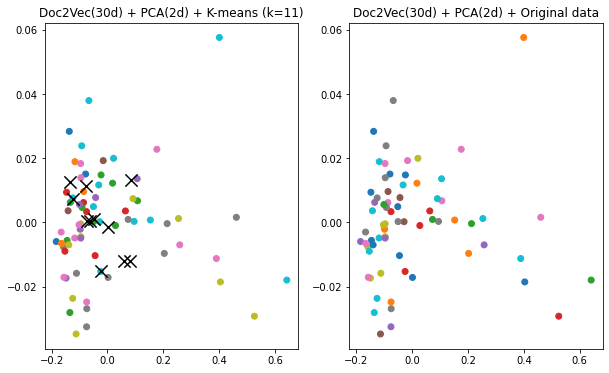

In [51]:
# Kmeans + Doc2Vec + PCA-2D
import nltk
from nltk.cluster import KMeansClusterer
from sklearn.decomposition import PCA

# Total number of authors, try that again with other relevant "K"s
NUM_CLUSTERS = 11

kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=60)
assigned_clusters = kclusterer.cluster(model.docvecs.doctag_syn0, assign_clusters=True)

pca = PCA(n_components=2).fit(model.docvecs.doctag_syn0)
datapoint = pca.transform(model.docvecs.doctag_syn0)

%matplotlib inline
plt.figure

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 6)

ax1.scatter(datapoint[:, 0], datapoint[:, 1], c=[i for i in assigned_clusters], cmap='tab10')
centroids = kclusterer.means()
centroidpoint = pca.transform(centroids)
ax1.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='x', s=150, c='#000000')
ax1.set_title('Doc2Vec(30d) + PCA(2d) + K-means (k=11)')

ax2.scatter(datapoint[:, 0], datapoint[:, 1], c=[i for i in encoded_raw_Y], cmap='tab10')
ax2.set_title('Doc2Vec(30d) + PCA(2d) + Original data')
fig.show()

Text(0.5, 1.0, 'TD-IDF + PCA(2D) - Real classes ')

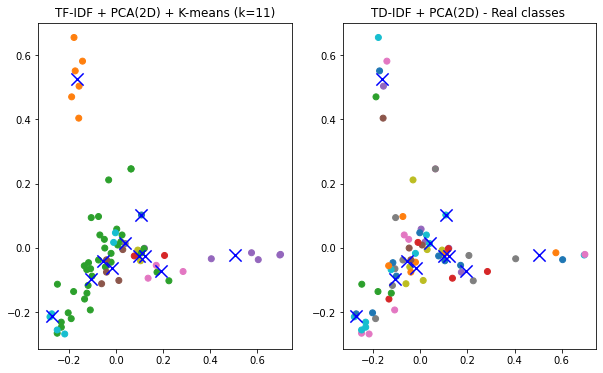

In [52]:
# Convert raw text to TF/IDF matrix and run Kmeans + PCA-2D
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
tfidf_transformer = TfidfVectorizer()
X_idf = tfidf_transformer.fit_transform(raw_df['Text'])
#print(X_idf.shape)
tfidf_transformer.get_feature_names()

cls = MiniBatchKMeans(n_clusters=11, random_state=7)
cls.fit(X_idf)
#print(cls.predict(X_idf))

# reduce the features to 2D
pca = PCA(n_components=2, random_state=7)
reduced_features = pca.fit_transform(X_idf.toarray())

# reduce the cluster centers to 2D
reduced_cluster_centers = pca.transform(cls.cluster_centers_)

# Display 
pred = cls.predict(X_idf)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 6)

ax1.scatter(reduced_features[:,0], reduced_features[:,1], c=pred, cmap='tab10')
ax1.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')
ax1.set_title('TF-IDF + PCA(2D) + K-means (k=11)')

ax2.scatter(reduced_features[:,0], reduced_features[:,1], c=encoded_raw_Y, cmap='tab10')
ax2.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='b')
ax2.set_title('TD-IDF + PCA(2D) - Real classes ')

In [53]:
# group documents by defined clusters
from collections import defaultdict

cluster_group = defaultdict()
for idx, cls in enumerate(assigned_clusters):
  if cls not in cluster_group.keys():
     cluster_group[cls] = []
  cluster_group[cls].append(documents[idx])

# get top N from each of the clusters
from nltk.probability import FreqDist

most_commom = {}
for clst in cluster_group.keys():
   fd = FreqDist([item for sublist in cluster_group[clst] for item in sublist])
   most_commom[clst] = fd.most_common(10)

# Cluster: 0 -> top 10 words, Cluster: 1 -> top 10 words..
most_commom 

{0: [('espécies', 10),
  ('nicho', 5),
  ('hotspot', 4),
  ('exemplo', 4),
  ('recursos', 4),
  ('r', 3),
  ('caso', 3),
  ('espécie', 3),
  ('plantas', 3),
  ('diferentes', 3)],
 1: [('assim', 8),
  ('espécies', 6),
  ('educação', 6),
  ('ensino-aprendizagem', 6),
  ('–', 5),
  ('recursos', 5),
  ('onde', 4),
  ('gameficação', 4),
  ('duas', 3),
  ('competição', 3)],
 2: [('–', 21),
  ('conhecimento', 17),
  ('meio', 14),
  ('educação', 13),
  (',', 11),
  ('grupos', 11),
  ('deve', 10),
  ('importância', 10),
  ('conferência', 10),
  ('indivíduos', 10)],
 3: [('espécies', 14),
  ('–', 10),
  ('definição:', 8),
  ('onde', 7),
  ('recursos', 7),
  ('conservação', 6),
  ('ecologia', 5),
  ('espécies.', 5),
  ('assim', 5),
  ('construção', 5)],
 4: [('ser', 8),
  ('forma', 8),
  ('r:', 8),
  ('maneira', 7),
  ('utilizada', 7),
  ('recursos', 6),
  ('podem', 6),
  ('além', 6),
  ('escola', 6),
  ('formação', 6)],
 5: [('pois', 5),
  ('sim,', 4),
  ('novos', 4),
  ('assim', 3),
  ('ciência

k:3
Clusters: 
[0 0 0 0 0 0 0 0 0 0 0 0 2 2 0 2 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 2 1 0 0 0
 0 0 2 2 2 2 0 0 0 0 0 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 2 1]
AVG Silhouette_score: 0.61477554
k:4
Clusters: 
[1 1 3 1 3 3 3 1 1 3 3 3 2 2 3 2 3 3 1 1 2 3 1 1 3 3 3 3 1 1 1 1 2 0 1 3 1
 1 1 2 2 2 2 3 3 3 3 1 1 0 2 1 1 1 1 1 3 1 1 1 3 3 3 1 0 1 0 2 0]
AVG Silhouette_score: 0.49635193
k:5
Clusters: 
[0 0 1 0 1 1 1 0 0 1 1 1 2 2 1 2 1 1 0 0 2 1 0 0 1 1 1 1 0 0 0 0 2 3 0 1 0
 0 0 2 2 2 2 1 1 1 1 0 0 3 2 0 0 0 0 0 1 0 0 0 1 1 1 0 3 0 3 2 4]
AVG Silhouette_score: 0.50011665
k:6
Clusters: 
[2 2 1 2 1 1 1 2 5 1 1 1 0 0 1 0 1 1 2 2 0 1 5 2 1 1 1 1 2 2 5 5 0 3 5 1 2
 2 2 0 0 0 0 1 1 1 1 5 2 3 0 2 5 5 5 2 1 2 2 2 1 1 1 2 3 5 3 0 4]
AVG Silhouette_score: 0.52675676
k:7
Clusters: 
[2 2 0 2 0 0 0 2 5 0 0 0 1 1 0 1 0 0 2 2 1 0 5 2 0 0 0 0 2 2 5 5 1 3 5 0 2
 2 2 6 6 6 1 0 0 0 0 5 2 3 6 2 5 5 5 2 0 2 2 2 0 0 0 2 3 5 3 6 4]
AVG Silhouette_score: 0.5512675
k:8
Clusters: 
[0 0 5 0 5 7 7 0 2 7 5 7 1 1 7 1 7 7 0 0 

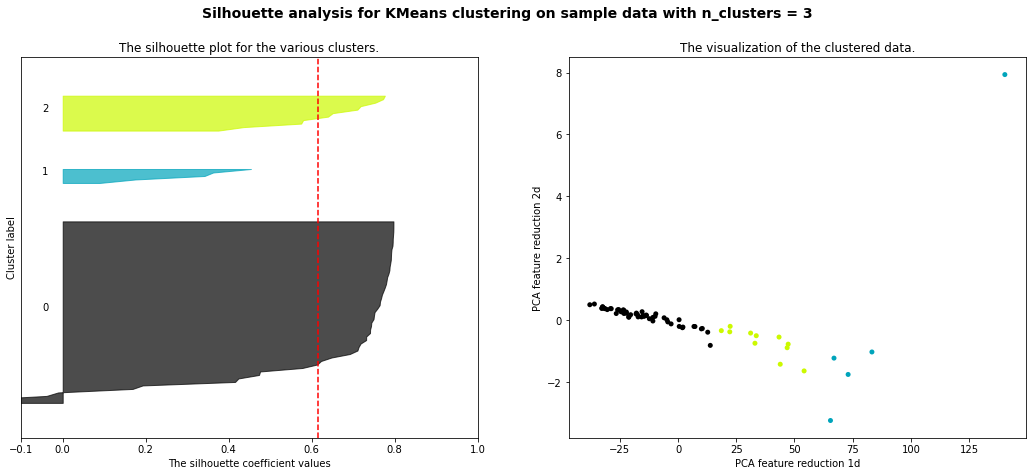

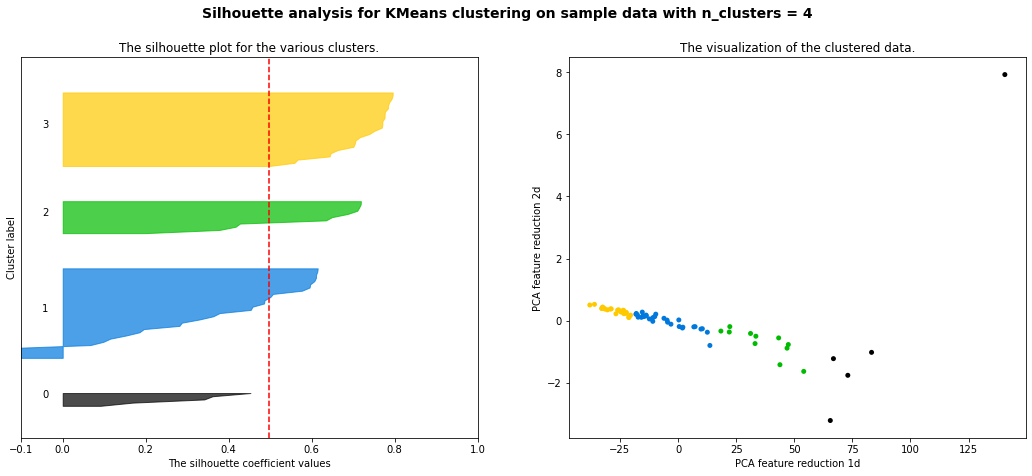

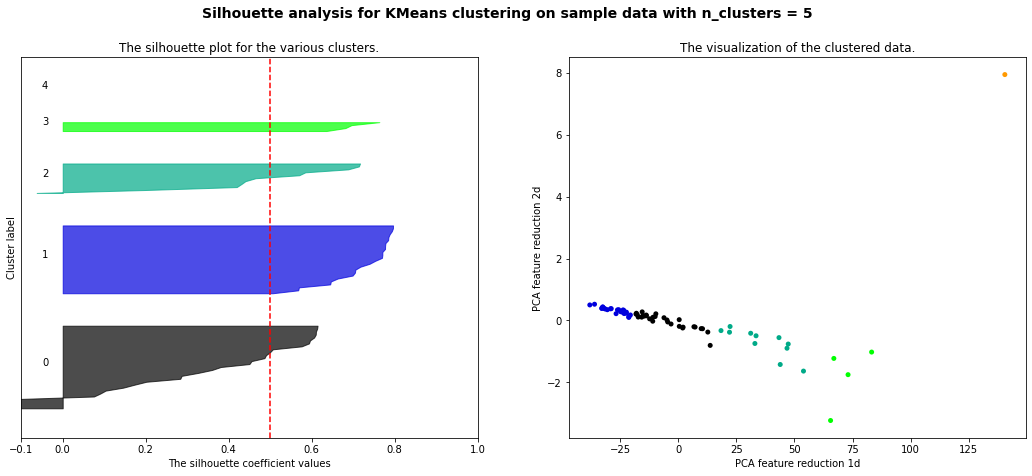

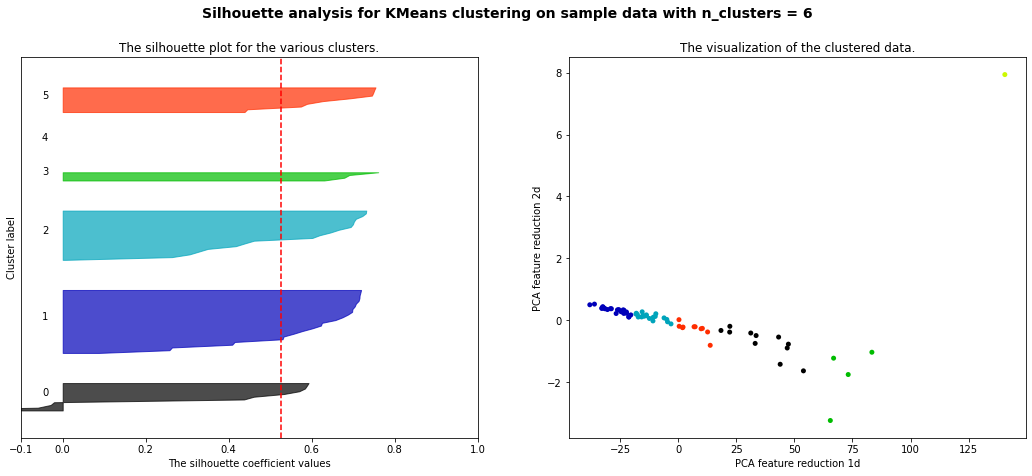

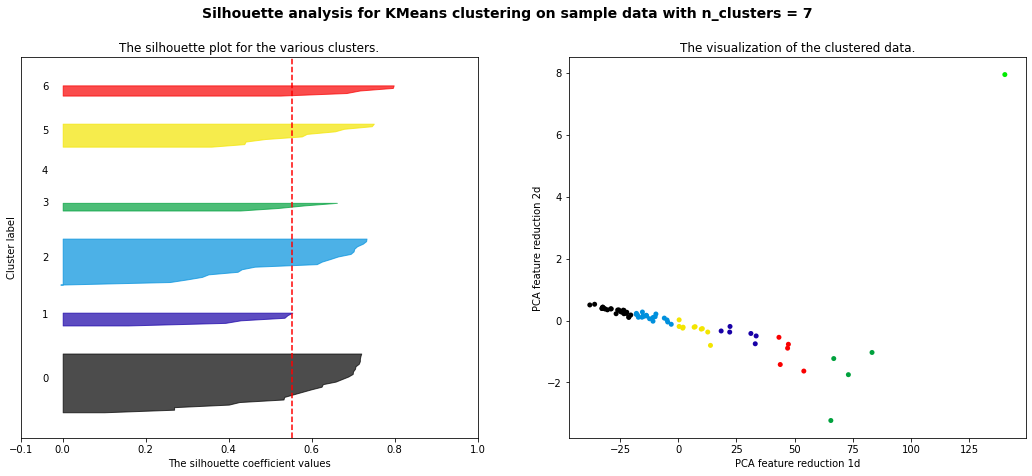

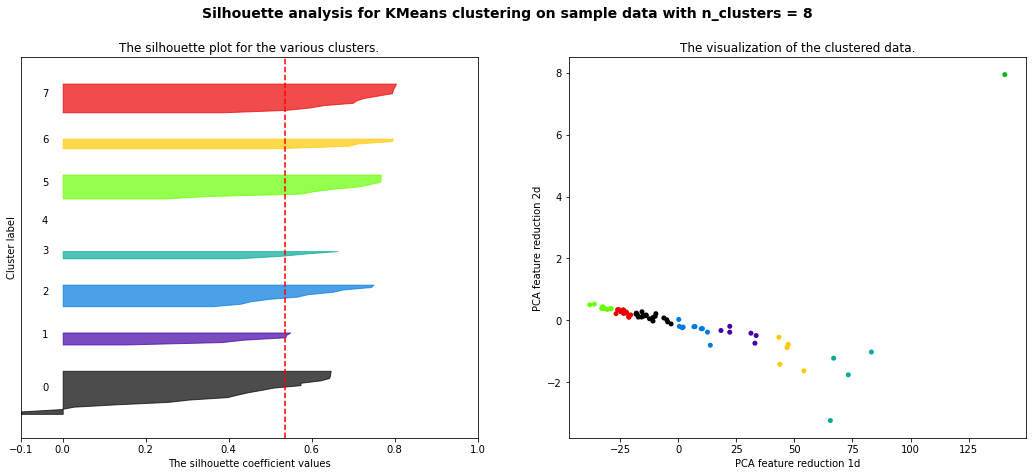

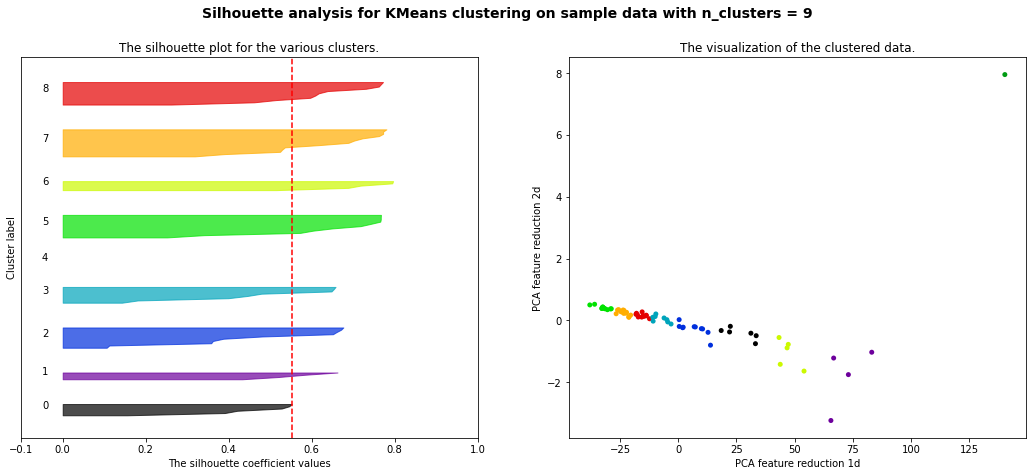

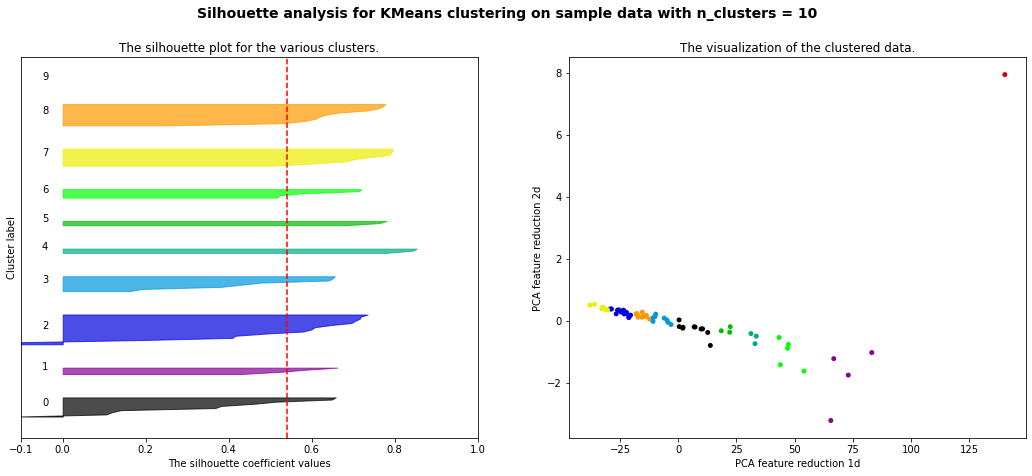

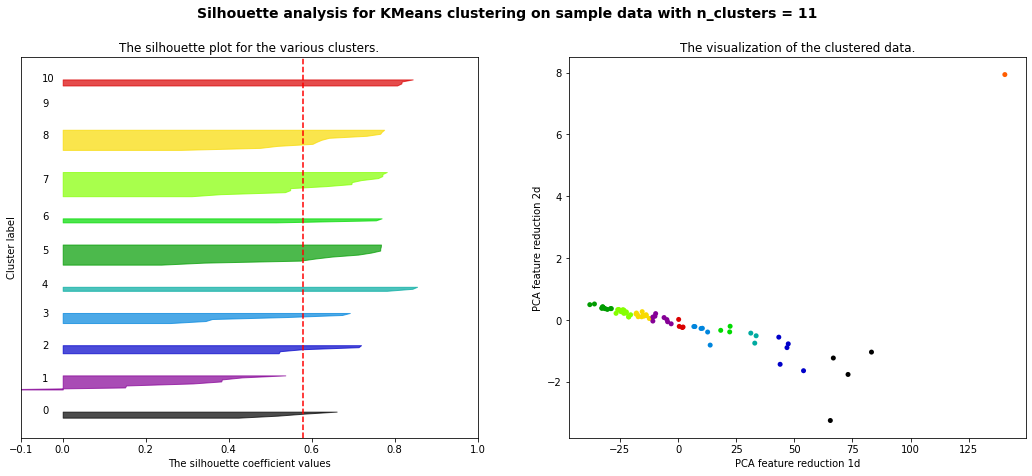

In [54]:
# Running Birch (hierarchical clustering) increasing number of clusters to check for silhuete average and data dist

start_alpha=0.01
infer_epoch=1000
for k in range(3, 12):

  fig, (ax1, ax2) = plt.subplots(1, 2)
  fig.set_size_inches(18, 7)

  ax1.set_xlim([-0.1, 1])
  ax1.set_ylim([0, len(raw_df) + (k + 1) * 10])
  n_clusters = k
  print('k:' + str(k))
  brc = Birch(branching_factor=50, n_clusters=n_clusters, threshold=0.1, compute_labels=True)

  X=[]
  for d in documents:
      X.append(model.infer_vector(d, alpha=start_alpha, steps=infer_epoch) )
      

  brc.fit(X)
  clusters = brc.predict(X)
  labels = brc.labels_
  
  print ("Clusters: ")
  print (clusters)
  
  silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
  print ("AVG Silhouette_score: " + str(silhouette_score))
  
  sample_silhouette_values = metrics.silhouette_samples(X, clusters)
  y_lower = 10
  for i in range(k):

    ith_cluster_silhouette_values = sample_silhouette_values[labels == i]

    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / n_clusters)
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    y_lower = y_upper + 10

  ax1.set_title("The silhouette plot for the various clusters.")
  ax1.set_xlabel("The silhouette coefficient values")
  ax1.set_ylabel("Cluster label")

  ax1.axvline(x=silhouette_score, color="red", linestyle="--")

  ax1.set_yticks([])  # Clear the yaxis labels / ticks
  ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

  colors = cm.nipy_spectral(clusters.astype(float) / n_clusters)
  
  # reduce the cluster centers to 2D
  pca = PCA(n_components=2, random_state=7)
  reduced_cluster_centers = pca.fit_transform(X)
  ax2.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:, 1], marker='.', s=100, lw=0, alpha=1,
              c=colors, cmap='tab20')

  # !!! Labeling the clusters - Could not retrieve the centroids from Birch model !!!
  
  # centers = clusterer.cluster_centers_
  # ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
  #             c="white", alpha=1, s=200, edgecolor='k')

  # for i, c in enumerate(centers):
  #     ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
  #                 s=50, edgecolor='k')

  ax2.set_title("The visualization of the clustered data.")
  ax2.set_xlabel("PCA feature reduction 1d")
  ax2.set_ylabel("PCA feature reduction 2d")

  plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                "with n_clusters = %d" % n_clusters),
                fontsize=14, fontweight='bold')

plt.show()

In [0]:
# Train model for TNSE reduction
tsne = TSNE(n_components=2, verbose=0, perplexity=40, n_iter=300)
tsne_results = tsne.fit_transform(model.docvecs.doctag_syn0)
xpts_tsne = tsne_results[:,0]
ypts_tsne = tsne_results[:,1]

PCA = PCA(n_components=2, random_state=7)
pca_results = tsne.fit_transform(model.docvecs.doctag_syn0)
xpts_pca = pca_results[:,0]
ypts_pca = pca_results[:,1]

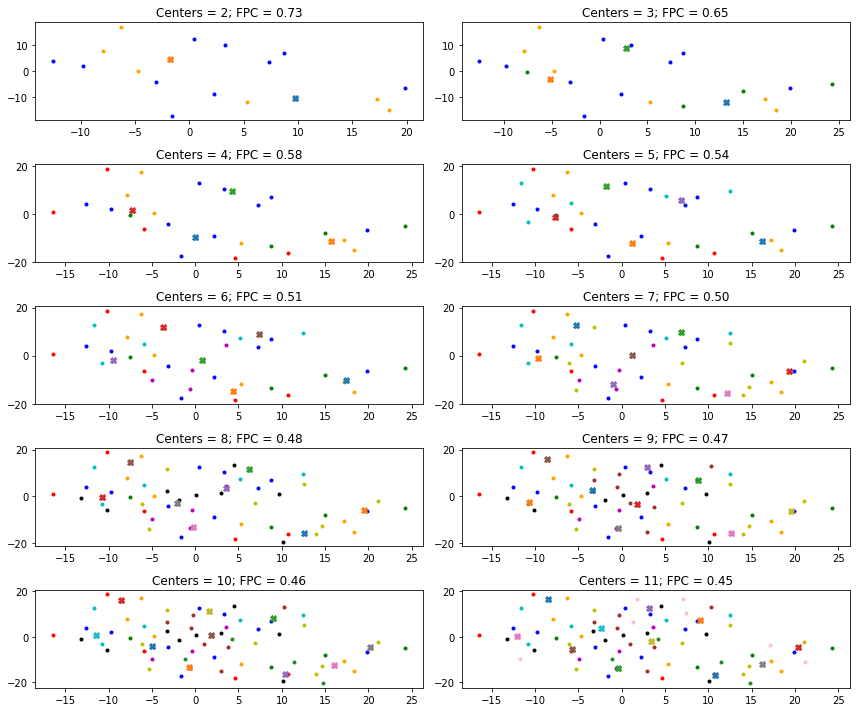

In [56]:
# Go from 2 to 10 clusters doing fuzzy-partition + TSNE-2D
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import skfuzzy as fuzz

colors = ['b', 'orange', 'g', 'r', 'c', 'm', 'y', 'k', 'Brown', 'ForestGreen', 'pink']

def plot_clusters(data):
  fig1, axes1 = plt.subplots(5, 2, figsize=(10,10))
  fig1.set_figwidth(12)
  fpcs = []

  for ncenters, ax in enumerate(axes1.reshape(-1), 2):
    cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
        np.vstack((xpts_tsne, ypts_tsne)), ncenters, 2, error=0.005, maxiter=1000, init=None)

    # Store fpc values for later
    fpcs.append(fpc)

    # Plot assigned clusters, for each data point in training set
    cluster_membership = np.argmax(u, axis=0)
    for j in range(ncenters):
        ax.plot(xpts_tsne[encoded_Y == j],
                ypts_tsne[encoded_Y == j], '.', color=colors[j])

    # Mark the center of each fuzzy cluster
    for pt in cntr:
        ax.plot(pt[0], pt[1], 'X')

    ax.set_title('Centers = {0}; FPC = {1:.2f}'.format(ncenters, fpc))
    #ax.axis('off')

  fig1.tight_layout()
  return fpcs

tsne_fpcs = plot_clusters(np.vstack((xpts_tsne, ypts_tsne)))

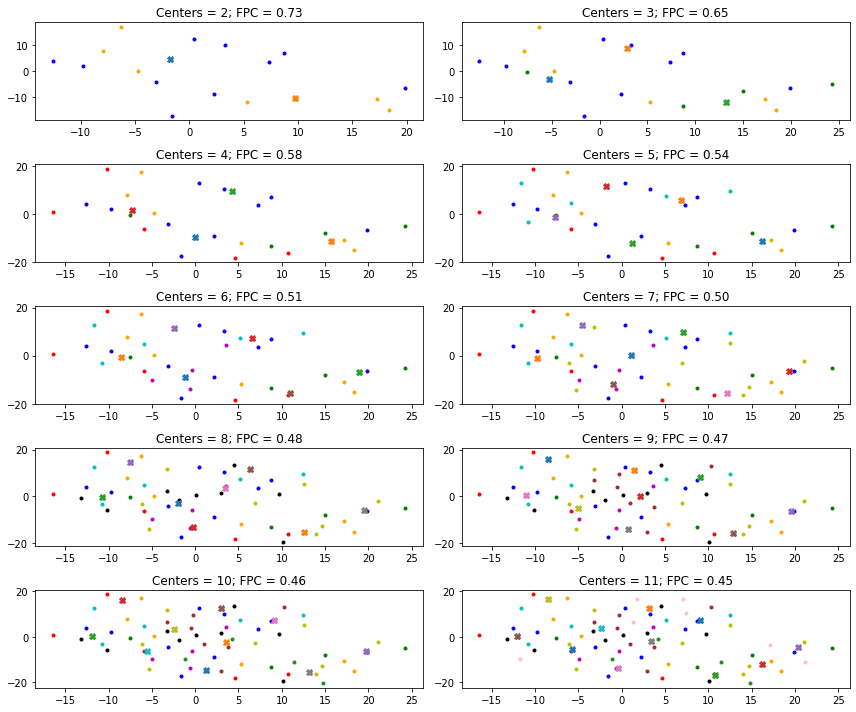

In [57]:
pca_fpcs = plot_clusters(np.vstack((xpts_pca, ypts_pca)))

Text(0.5, 1.0, 'FPC on PCA 2D')

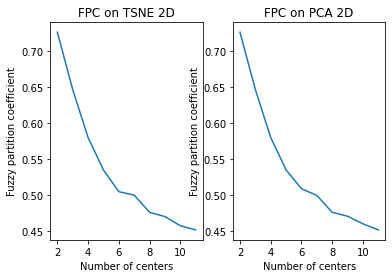

In [58]:
#Plot fuzzy partition coefficient (closer to 1 is better)
fig2, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(np.r_[2:12], tsne_fpcs)
ax1.set_xlabel("Number of centers")
ax1.set_ylabel("Fuzzy partition coefficient")
ax1.set_title('FPC on TSNE 2D')

ax2.plot(np.r_[2:12], pca_fpcs)
ax2.set_xlabel("Number of centers")
ax2.set_ylabel("Fuzzy partition coefficient")
ax2.set_title('FPC on PCA 2D')

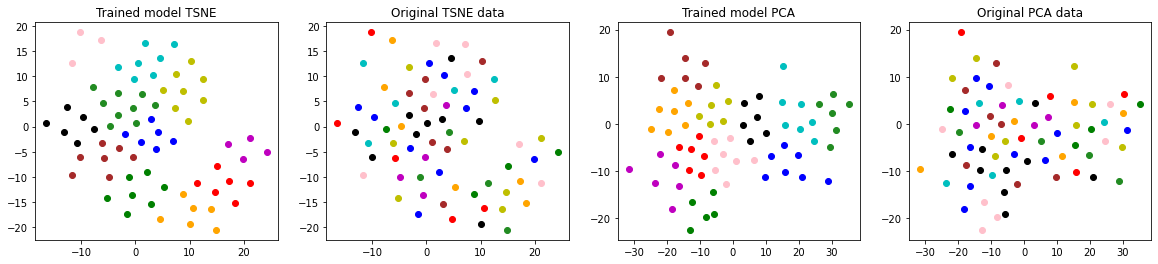

In [59]:
tsne_data = np.vstack((tsne_results[:,0], tsne_results[:,1]))
cntr, u_orig_tsne, _, _, _, _, _ = fuzz.cluster.cmeans(
    tsne_data, 11, 2, error=0.005, maxiter=1000)


pca_data = np.vstack((pca_results[:,0], pca_results[:,1]))
cntr, u_orig_pca, _, _, _, _, _ = fuzz.cluster.cmeans(
    pca_data, 11, 2, error=0.005, maxiter=1000)

fig2, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4)
fig2.set_figwidth(20)
ax1.set_title('Trained model TSNE')
ax2.set_title('Original TSNE data')

ax3.set_title('Trained model PCA')
ax4.set_title('Original PCA data')

for j in range(11):
    ax1.plot(tsne_data[0, u_orig_tsne.argmax(axis=0) == j],
             tsne_data[1, u_orig_tsne.argmax(axis=0) == j], 'o',
             label=str(j), color=colors[j])
    
    ax2.plot(tsne_data[0 , encoded_raw_Y == j],
             tsne_data[1 , encoded_raw_Y == j], 'o',
             label=str(j), color=colors[j])
    
    ax3.plot(pca_data[0, u_orig_pca.argmax(axis=0) == j],
             pca_data[1, u_orig_pca.argmax(axis=0) == j], 'o',
             label=str(j), color=colors[j]) 
    ax4.plot(pca_data[0 , encoded_raw_Y == j],
             pca_data[1 , encoded_raw_Y == j], 'o',
             label=str(j), color=colors[j])



In [60]:
word_embedding_dict['branco'].shape

(50,)

In [0]:
# Using GloVe instead of Doc2Vec/TD-IDF (Building the padding matrix)

def build_weighted_matrix(corpus, glove_embedding):
  weighted_documents = []
  for idx, text in enumerate(corpus):
      phrase = []
      for word in text.split(' '):
          document = np.zeros((50))
          embedding_vector = glove_embedding.get(word.lower())
          if embedding_vector is not None:
              document = embedding_vector[:50]
          phrase.append(document)
      weighted_documents.append(phrase)
  return weighted_documents


matrix = build_weighted_matrix(raw_df['Text'], word_embedding_dict)

padded_matrix = pad_sequences(matrix, max([len(i) for i in matrix]), padding='post', dtype='float32')

In [62]:
len(matrix[0])

196

In [63]:
model.docvecs.doctag_syn0.shape

(69, 30)

In [64]:
padded_matrix[0][0]

array([-0.066641, -0.051249, -1.074865, -1.16758 ,  0.031114, -0.232578,
       -0.851292,  0.335445, -0.56462 ,  0.678047,  0.194499, -0.063695,
       -0.134125,  0.962997, -0.532836,  0.564643,  0.249037, -0.528887,
        0.284368,  1.128947,  1.866813,  0.08734 ,  0.463937, -0.444925,
       -1.022876, -1.06115 , -0.296256,  0.134193,  0.43059 ,  0.171846,
        0.042674, -0.480062,  0.338666, -0.116538, -0.189947, -1.067698,
       -0.442694, -0.847708, -1.253818, -0.664441, -0.029178, -0.23111 ,
        0.4899  , -0.135933, -0.034312,  0.049583,  0.204851,  0.139553,
       -1.053818, -0.520724], dtype=float32)

Text(0.5, 1.0, 'Plot da matriz de documentos + TSNE')

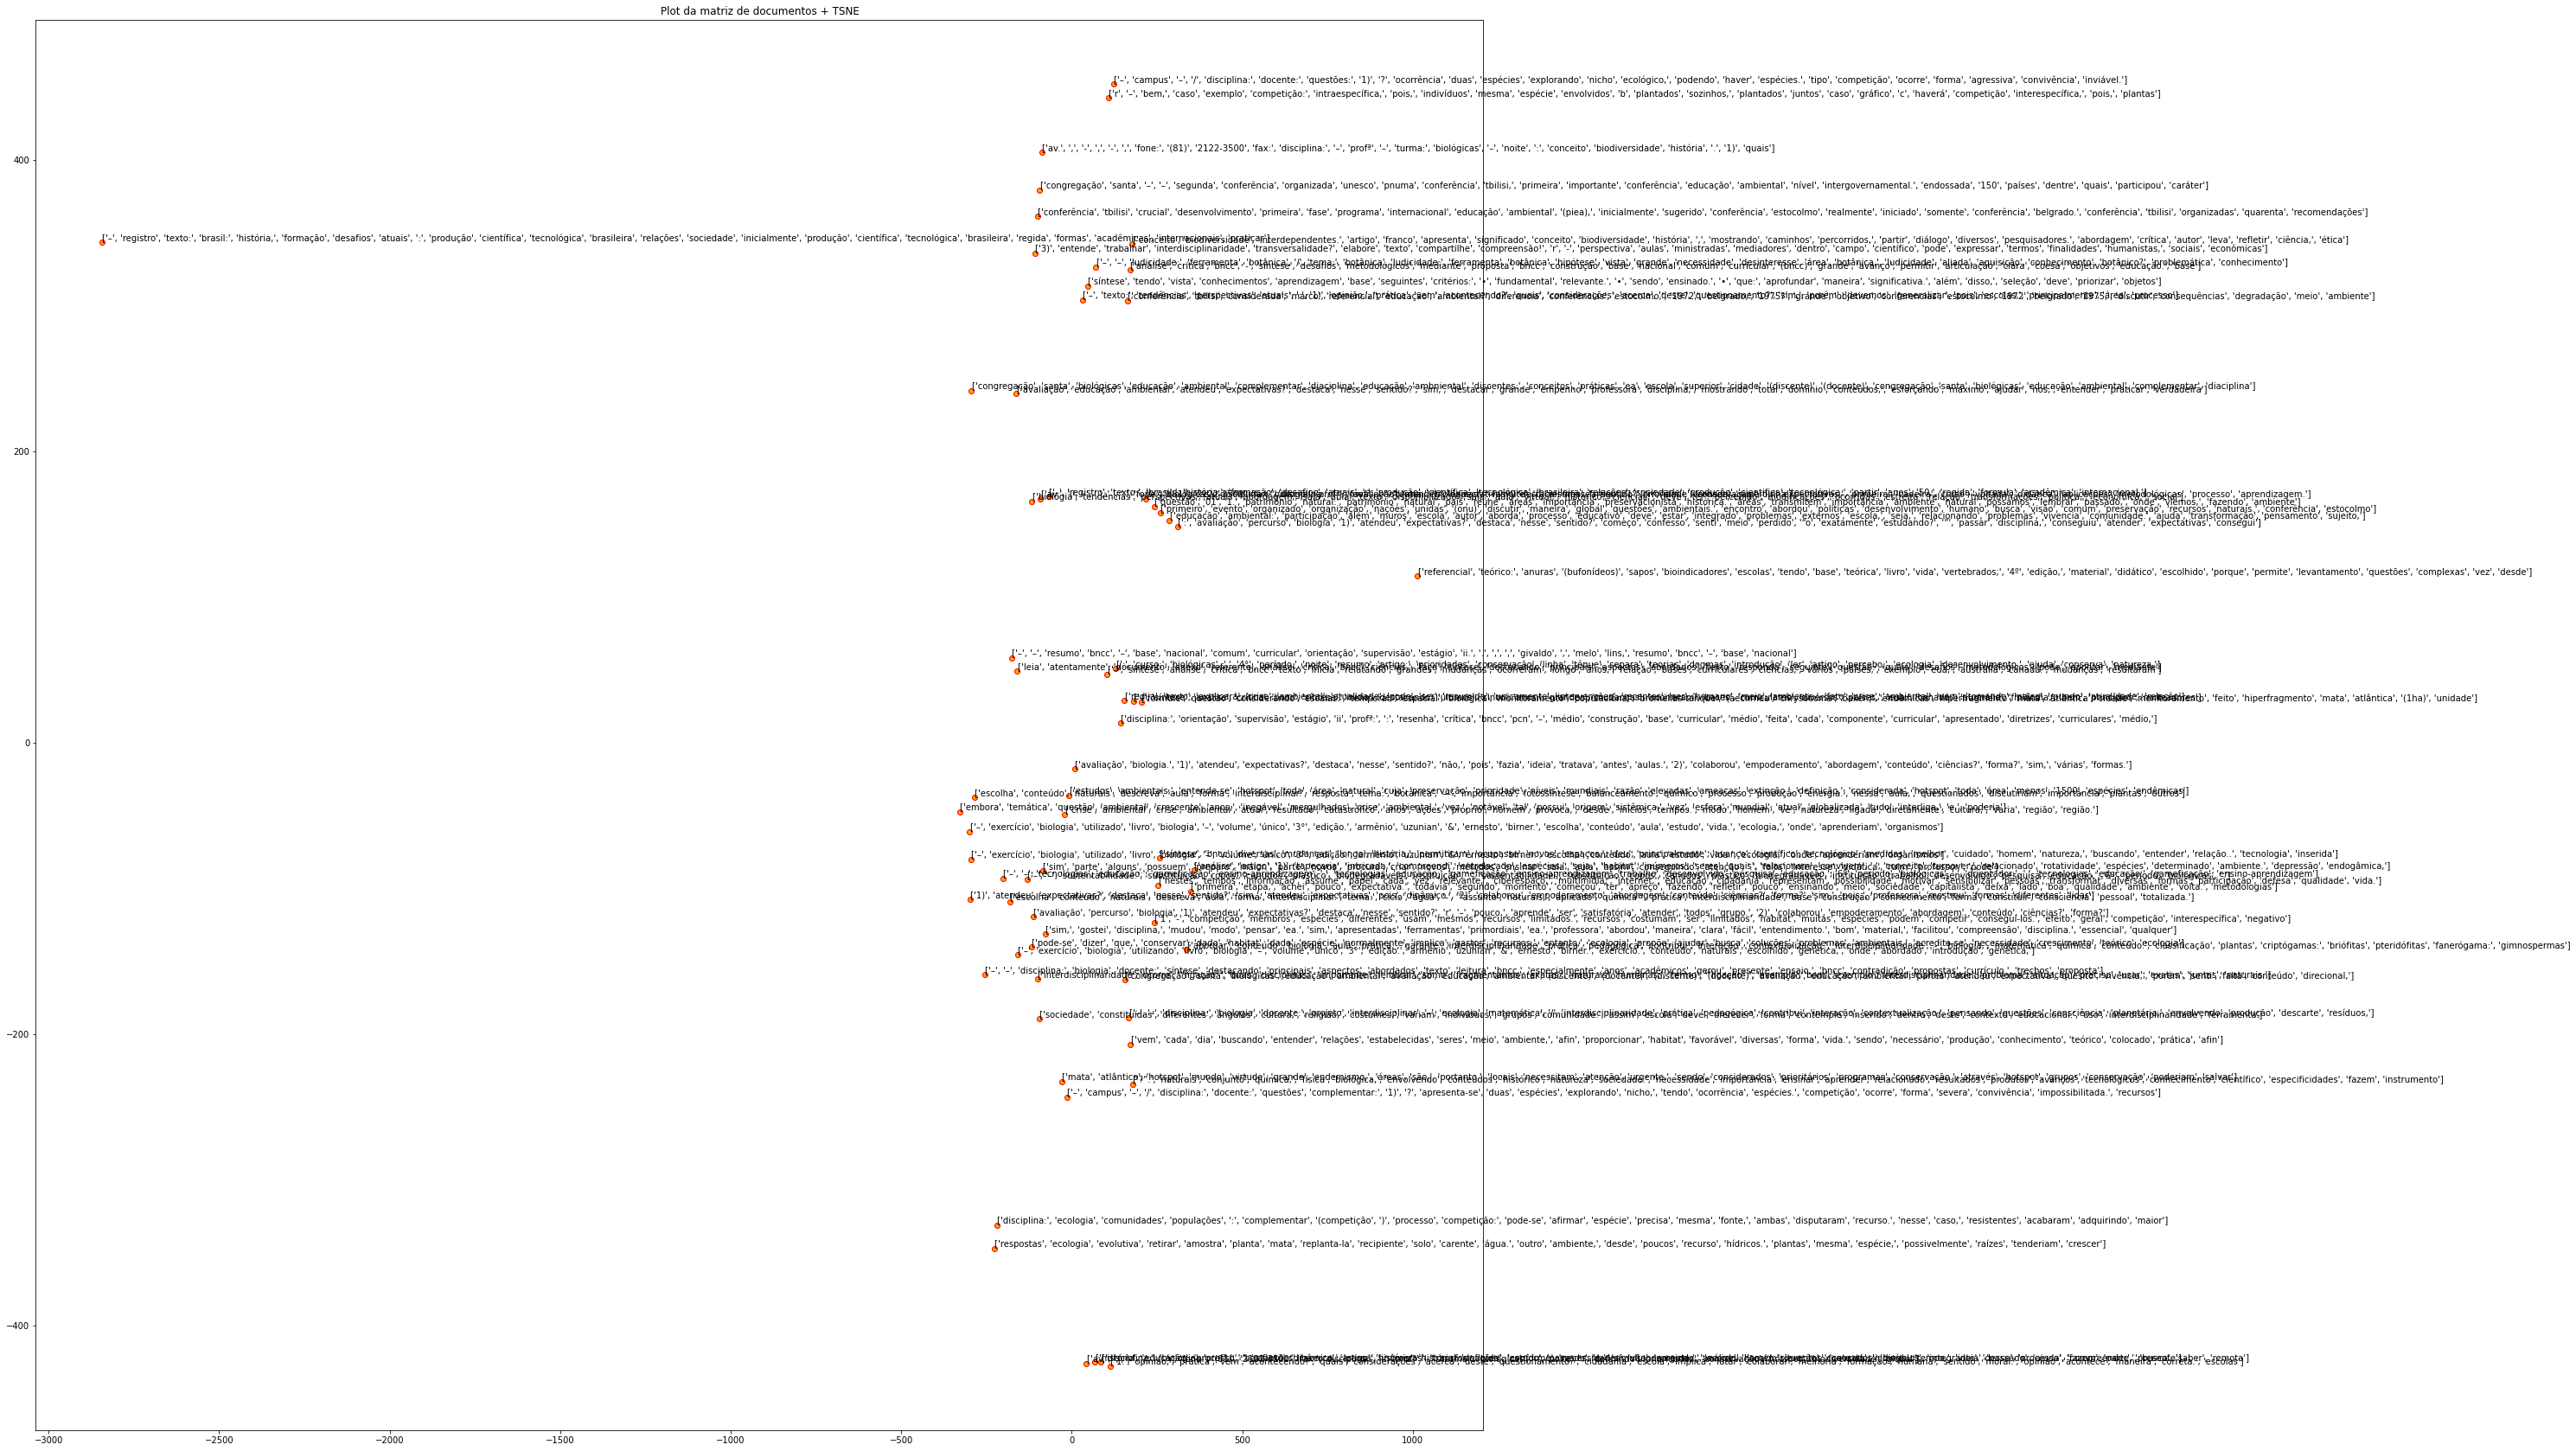

In [65]:
#Plot raw document contents with TSNE

tokenizer = RegexpTokenizer(r'\w+')
tokenized_corpus = [tokenizer.tokenize(document) for document in raw_df['Text']]

# Set values for various parameters
feature_size = 10    # Word vector dimensionality  
window_context = 10          # Context window size                                                                                    
min_word_count = 1   # Minimum word count                        
sample = 1e-3   # Downsample setting for frequent words

w2v_model = word2vec.Word2Vec(tokenized_corpus, size=feature_size, 
                              window=window_context, min_count = min_word_count,
                              sample=sample, iter=100)
                              
# If we want to plot words instead
# words = model.wv.index2word
# wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=5000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(model.docvecs.doctag_syn0)
labels = documents

plt.figure(figsize=(30, 30))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label[:25], xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

plt.title('Plot da matriz de documentos + TSNE')

Text(0.5, 1.0, 'Plot da matriz de documentos + PCA')

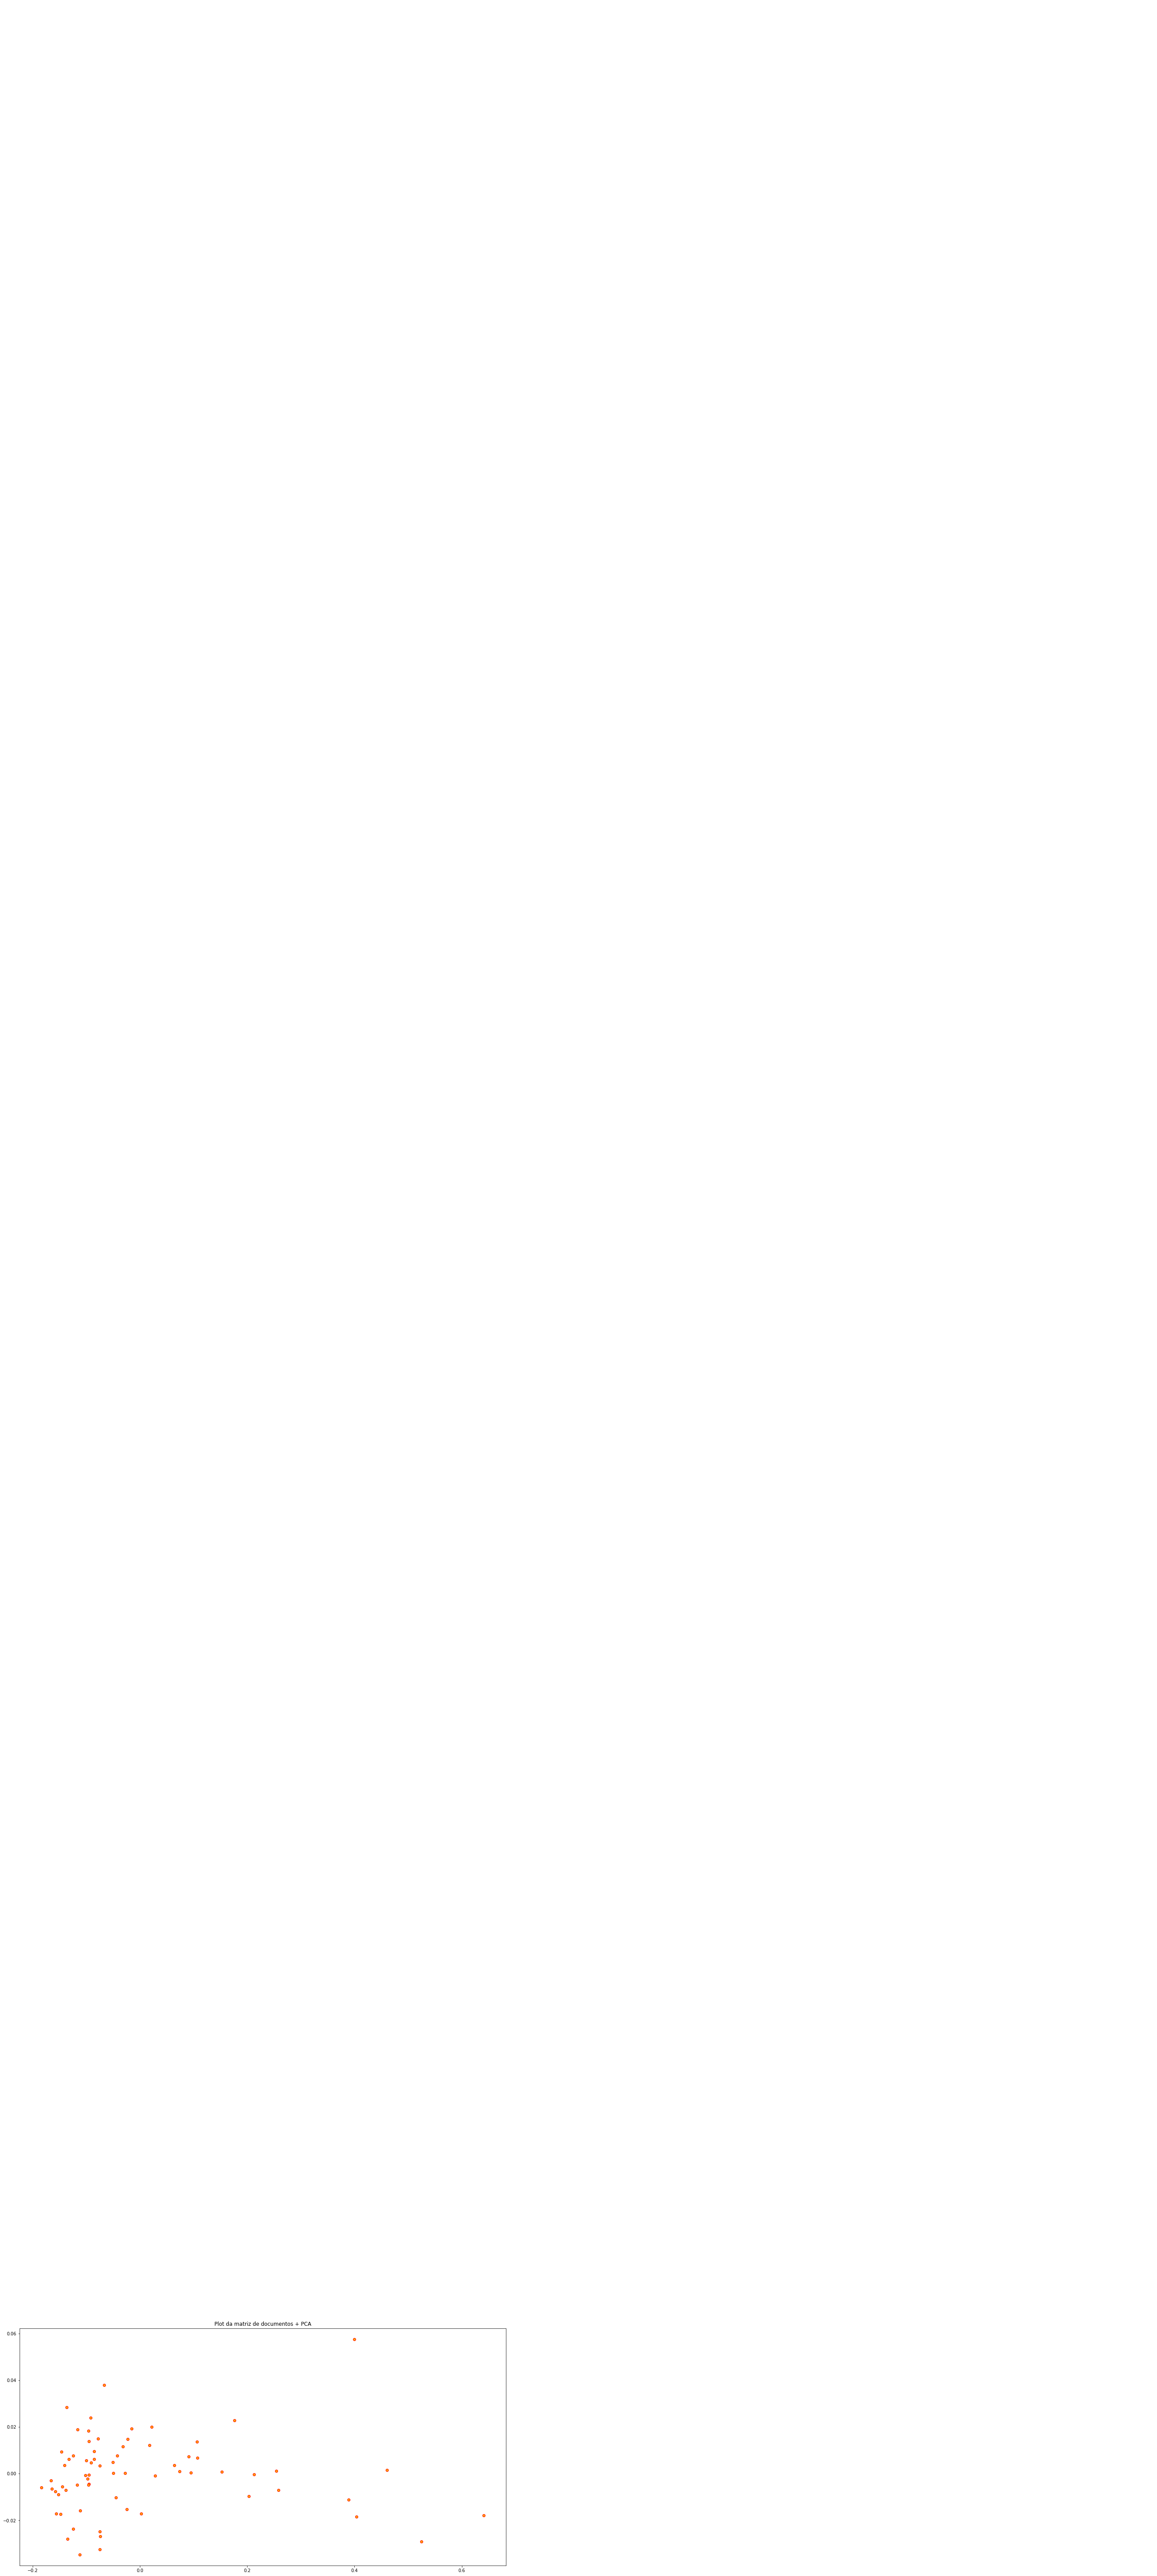

In [86]:
#TODO: Check why PCA does not display textual contents the same way as TSNE
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=0)
P = pca.fit_transform(model.docvecs.doctag_syn0)
np.set_printoptions(suppress=True)

labels = documents

fig2, (ax1) = plt.subplots(1, 1)
fig2.set_figwidth(20)
fig2.set_figheight(10)

ax1.scatter(P[:, 0], P[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, P[:, 0], P[:, 1]):
    ax1.annotate(label[:5], xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

ax1.set_title('Plot da matriz de documentos + PCA')

In [0]:
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    print(label)
    print(x+1)
    print(y+1)

* Proximos passos: Inspecionar o contéudo de cada cluster para ver se temos alguma informação interessante
* Substituir a as abordagens Doc2Vec e TF/IDF para apenas a matrix do GloVe

Alguma outra sugestão Cléber?